In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
from line import Line
from warp_transformer import WarpTransformer
from calc_calibration import calibrate_camera_and_pickle_mtx_dist

In [2]:
calibrate_camera_and_pickle_mtx_dist()

Starting calibration process....
Calibration process complete! [pickled file saved to 'dist_pickle.p']


In [3]:
image = mpimg.imread('test_images/test4.jpg')
# load mtx, dist
dist_pickle = pickle.load(open('dist_pickle.p', "rb" ))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

print(mtx,"\n\n", dist)

[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] 

 [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]


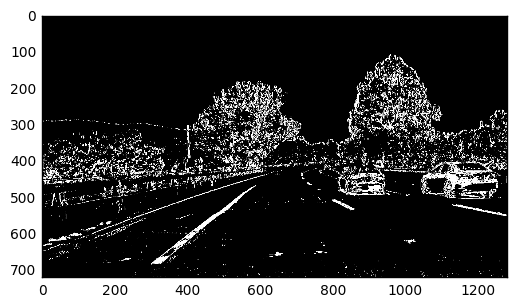

In [4]:
def threshold_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    '''From Advanced Lane Finding lesson, section 30'''
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # combined them here.
    combined = np.zeros_like(s_channel)
    combined[(sxbinary == 1) | (s_binary == 1)] = 1
    return combined

plt.imshow(threshold_pipeline(image),cmap='gray')
plt.show()


In [6]:
# Perspective transform
src = np.array([[262, 677], [580, 460], [703, 460], [1040, 677]]).astype(np.float32)
dst = np.array([[262, 720], [262, 0], [1040, 0], [1040, 720]]).astype(np.float32)

# Create transformer object
transformer = WarpTransformer(src, dst)

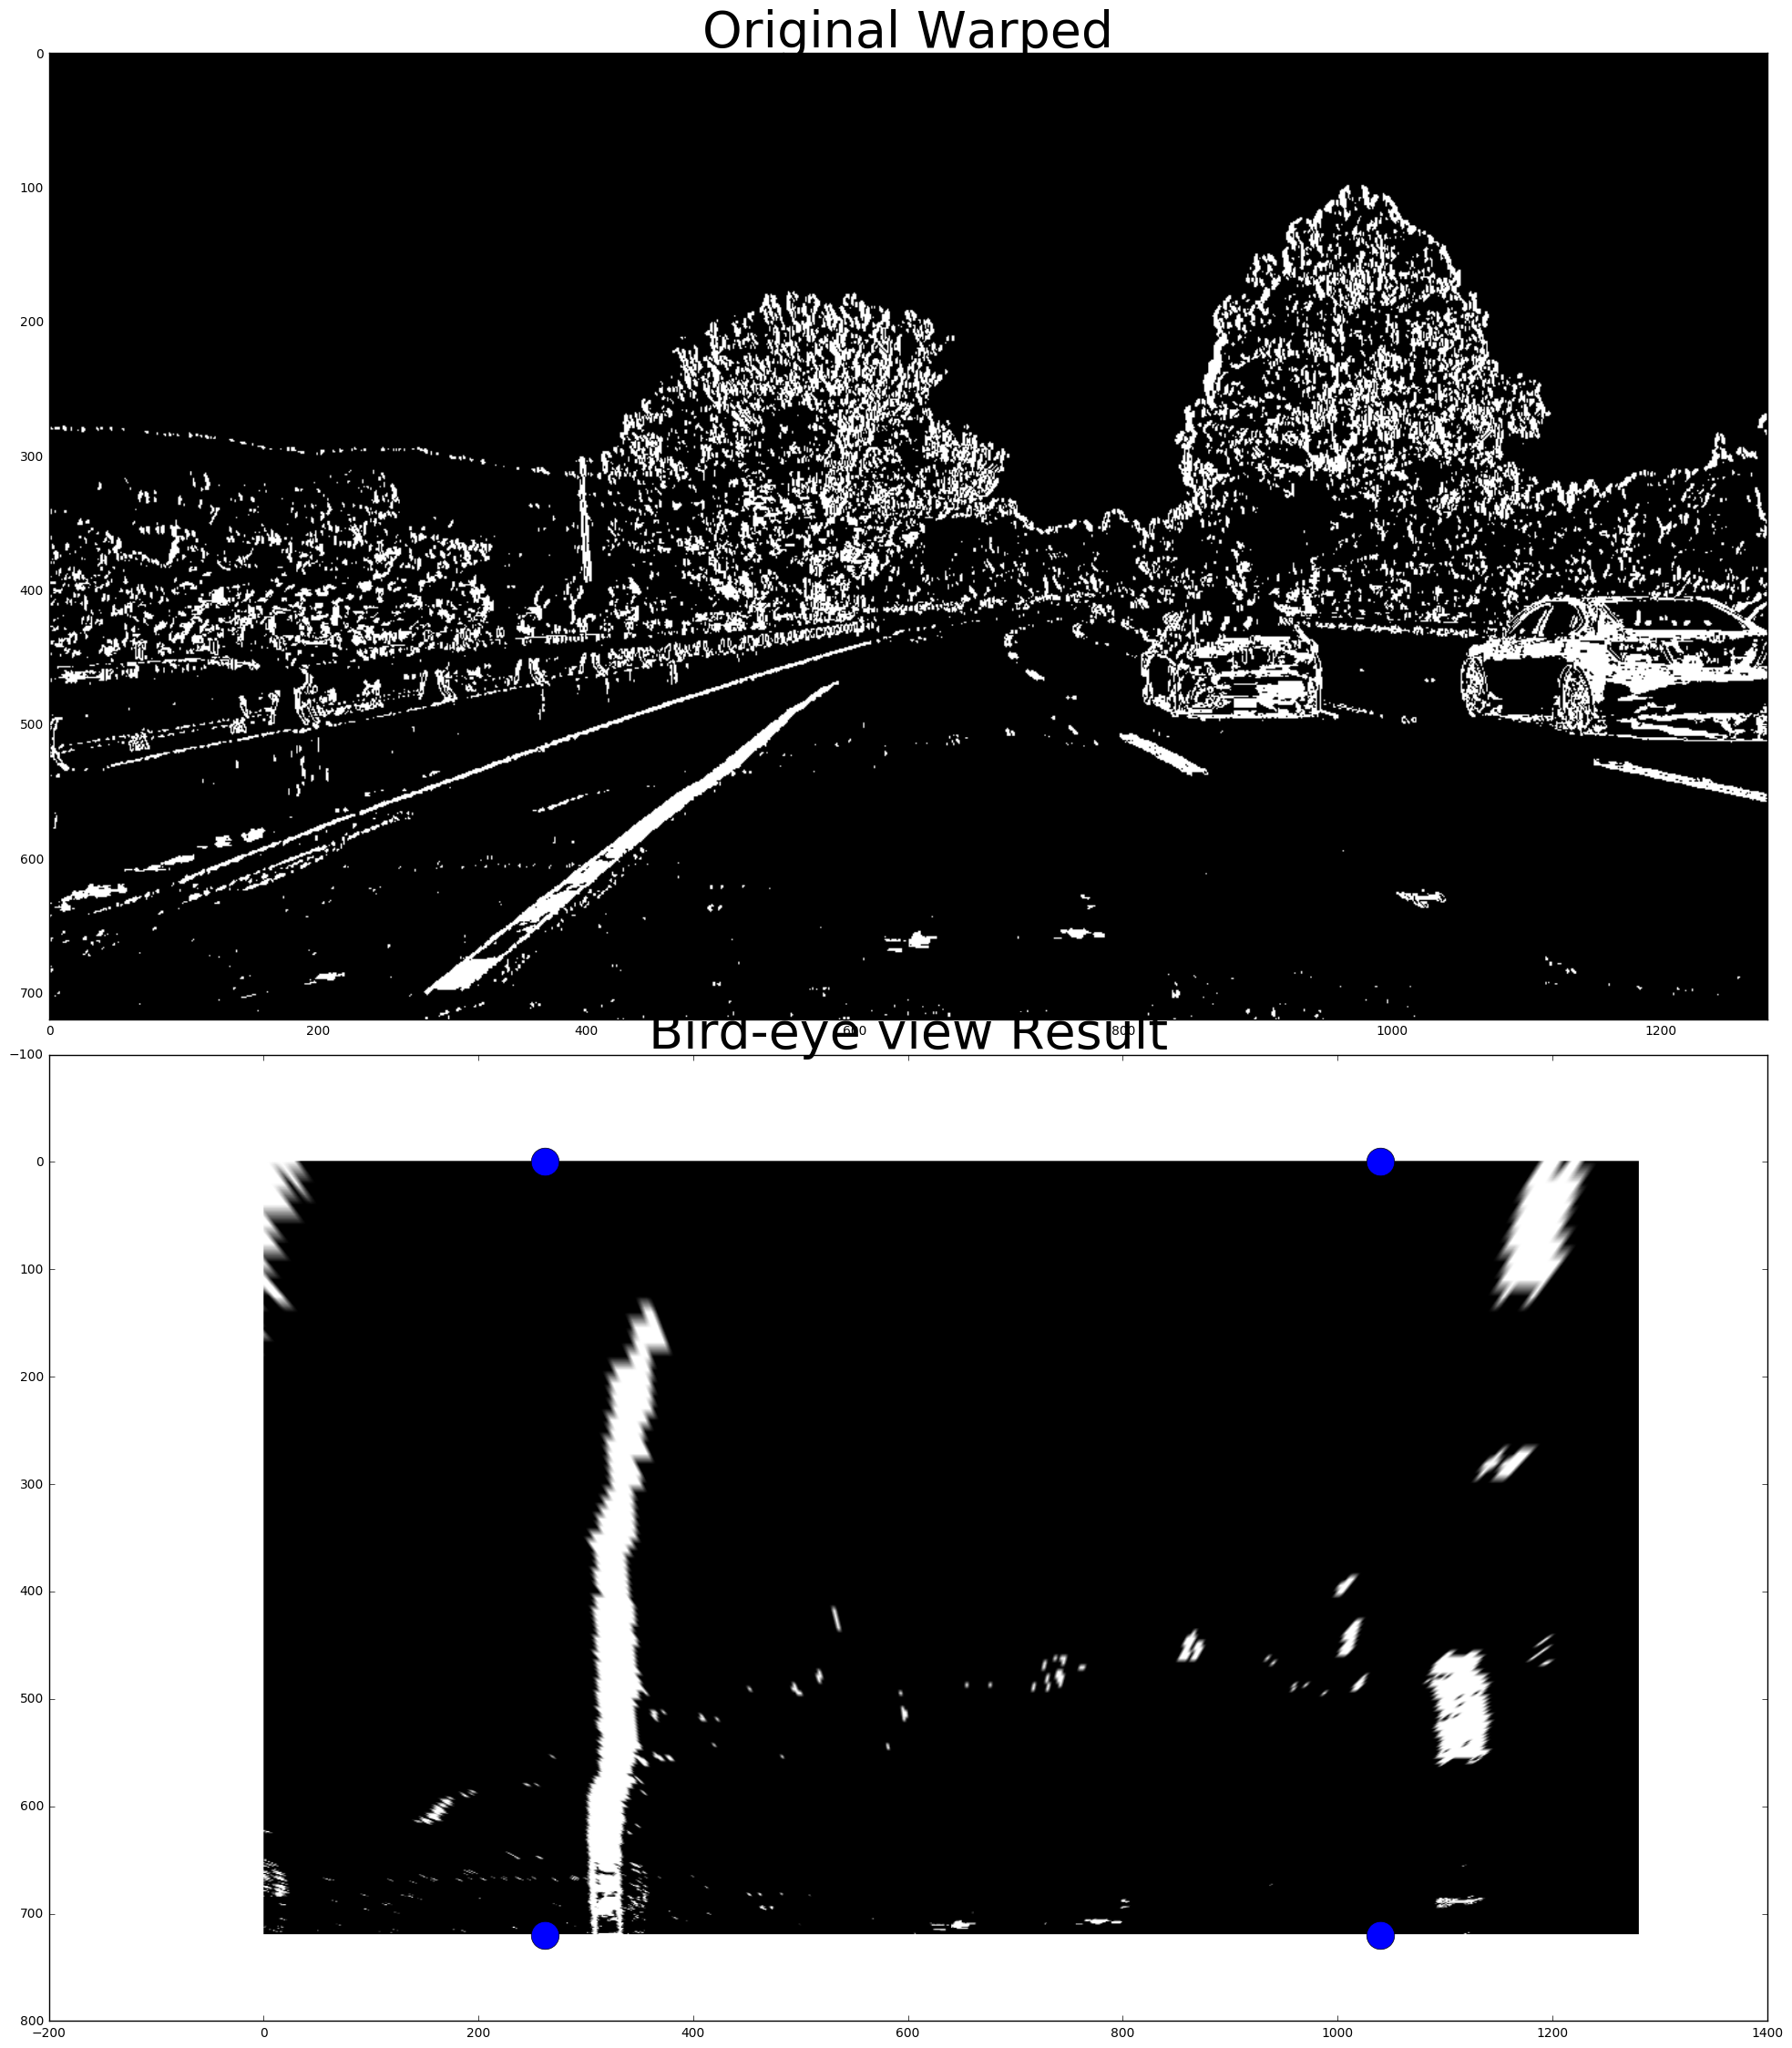

In [12]:
undist = cv2.undistort(image, mtx, dist, None, mtx)
combined = threshold_pipeline(undist)
binary_warped = transformer.to_birdview(combined)


# Plot the result
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 24))
f.tight_layout()

ax1.imshow(combined, cmap='gray')
# ax1.plot([p[0] for p in src], [p[1] for p in src], 'o', markersize=22)
ax1.set_title('Original Warped', fontsize=40)

ax2.imshow(binary_warped, cmap='gray')
ax2.plot([p[0] for p in dst], [p[1] for p in dst], 'o', markersize=22)
ax2.set_title('Bird-eye view Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()